CNNs anf GNNs as classifiers for sparse data events#
##Tutorial - Hands-on##

**Scope:** learn how to design and train a CNN and GNN architectures for a classification task

**Tasks:** <p>
Jet tagging (e.g. classification of jets originating from different particles: *gluons, quarks, Ws, Zs, and top quarks*).

**Physics context:** <p>
At the extreme energies of the Large Hadron Collider, massive particles can be produced with such high Lorentz boost that their decays into hadrons (hadron jets) are collimated in such a way that the resulting particles overlap. Deducing whether the substructure of an observed jet is due to a single low-mass particle or to multiple decay objects of a high-mass particle is an important problem in LHC data analysis. Traditional approaches are based on high-level observables built from theoretical models of energy deposition in calorimeters and charged tracks parameters reconsrtcuted in the inner tracker, but the complexity of the data makes this task an excellent candidate for the application of deep learning tools. The jet constituents can be in fact represented either as 2D or ND images,lending itself to the natural application of image classification techniques (CNN, ViT etc.), or as pointclouds/graphs, that can be classified with GNNs, or also as sequences, that can be analysed by RNNs or Transformers.

1.   create image-like and graph-like structures to represent jets from decays of different particles at an hadron collider using the *JetDataset*
2.   design and train a CNN architecture to classify jet image in one of the 5 categories: jet from [g,q,W,Z,t]
3.   design and train a GNN architecture (PointNet++) to classify jet graphs in one of the 5 categories: jet from [g,q,W,Z,t]
4.   assess performances of the two trained models

In [5]:
# install Pytorch Geometric
import torch
print(torch.__version__)


2.0.0a0+gite9ebda2


In [6]:
#imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import glob

import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

import torch.nn as nn
import torch.nn.functional as F

2.0.0a0+gite9ebda2
0.15.2a0+fa99a53


## Dataset:
The problem consists in identifying a given jet as a quark, a gluon, a W, a Z, or a top, based either on a **jet image**, i.e., a **2D histogram of the transverse momentum ($p_T$) deposited in each of 100x100 bins of a square window of the ($\eta,\phi$) plane, centered along the jet axis**, or on a **jet graph** structure, eg a graph with nodes the jet constituents

The jet constituents are stored in the **features** numpy array of shape (20000,100,16), where 100 is the number of jet constituents (if smaller than 100 is zero-padded to 100, if larger si trimmed to 100). and 16 is the number of features associated to each particle:

* the four-momentum in cartesian coordinates $(p_x,p_y,p_z,E)$
* the energy divided by the jet energy ($E_{rel}$)
* the transverse momentum ($p_T$), i.e. the momentum projected on the plane transverse to proton beams
* the momentum transverse to the jet direction ($p_{Trel}$)
* the pseudorapidity ($\eta$), a function of the polar angle (see https://en.wikipedia.org/wiki/Pseudorapidity)
* the pseudorapidity relative to the jet direction ($\eta_{rel}$)
* the pseudorapidity relative to the jet direction ($\eta_{rot}$) after a rotation is applied so that the jet image looks vertical
* the azimuth angle ($\phi$)
* the azimuth angle relative to the jet direction ($\phi_{rel}$)
* the azimuth angle relative to the jet direction ($\phi_{rot}$) after a rotation is applied so that the jet image looks vertical
* the $\Delta R = \sqrt{(\Delta\eta_{max})^2 + (\Delta\phi_{max})^2}$ of the jet
* the $\cos\theta$ of the jet
* the $\cos\theta_{rel}$ of the jet

The ground truth is incorporated in a **target** (['j_g', 'j_q', 'j_w', 'j_z', 'j_t]) numpy array of boolean with shape (20000,5) encoding the labels such that:

* $[1, 0, 0, 0, 0]$ for gluons
* $[0, 1, 0, 0, 0]$ for quarks
* $[0, 0, 1, 0, 0]$ f
or W bosons (with W -> qq)
* $[0, 0, 0, 1, 0]$ for Z bosons (with Z -> qq)
* $[0, 0, 0, 0, 1]$ for top quarks (with t -> Wq -> qqq)

This is what is called 'one-hot' encoding of a discrete label (typical of ground truth for classification problems).

In [7]:
# download dataset #the compute node is not connected to the network
#a local copy is available on my user home. This cell makes a copy of the data

#! git clone https://github.com/stefanogiagu/sgdatasets.git
#! ls -lh sgdatasets

import os
try:
    os.makedirs("sgdatasets/")
    !cp /leonardo/home/usertrain/a08trb55/dataset_jetTag.npz sgdatasets/
    print("data copied")
except FileExistsError:
    # directory already exists
    pass



In [8]:
# read dataset
with np.load('sgdatasets/dataset_jetTag.npz') as f:
  print(f.files)
  target = f['target']
  features = f['features']

# convert one-hot lables in integers labels (easier to manage in pytorch)
label = np.argmax(target, axis=1)

print(target.shape, label.shape, features.shape)

['target', 'features']
(20000, 5) (20000,) (20000, 100, 16)


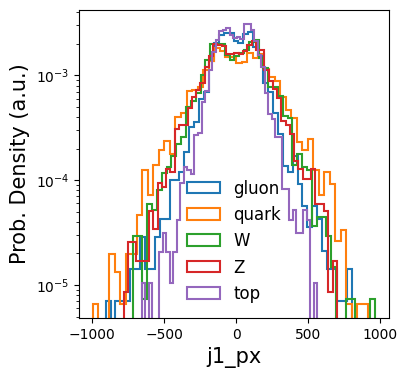

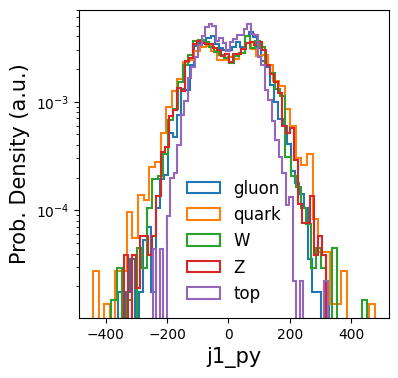

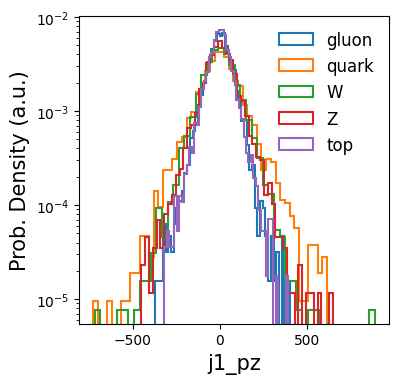

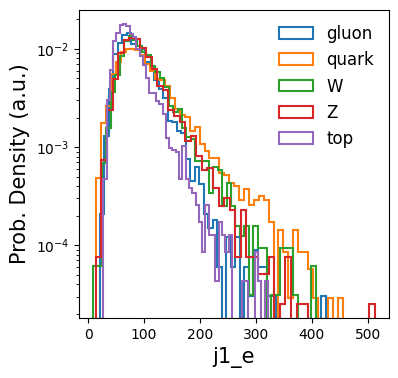

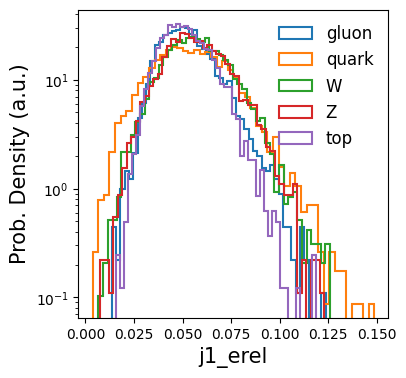

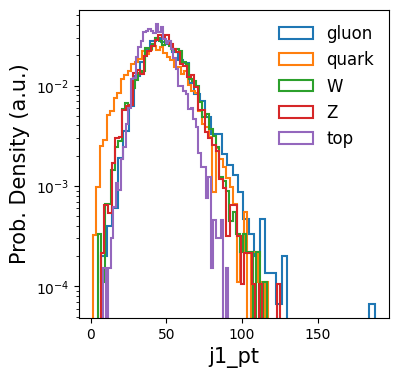

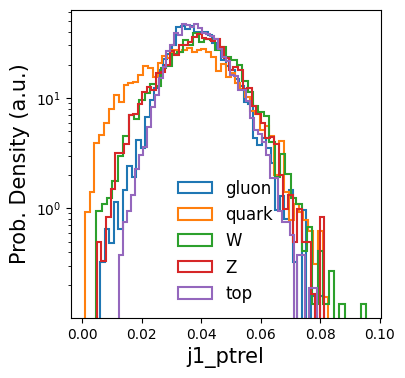

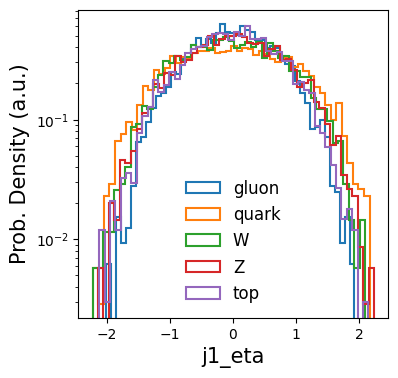

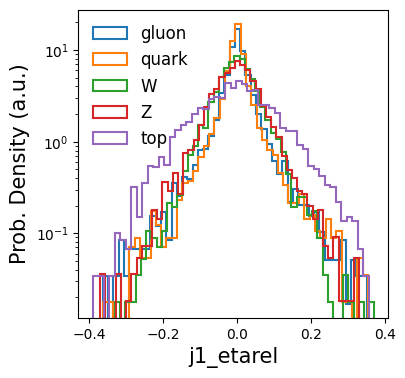

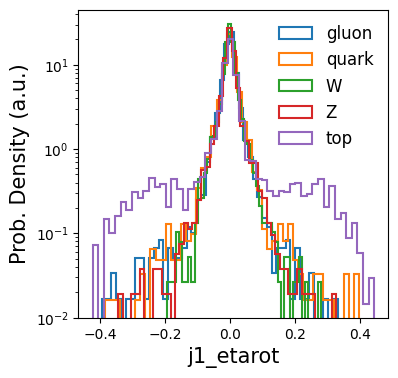

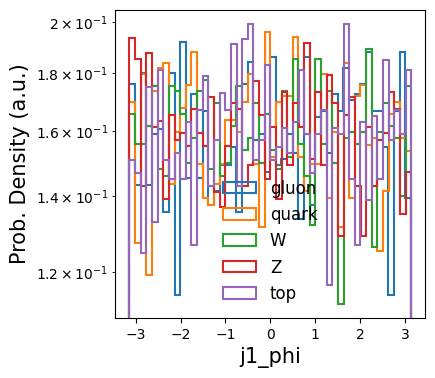

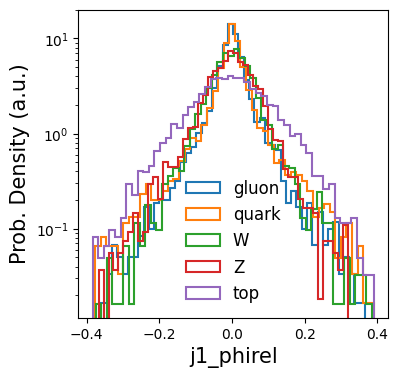

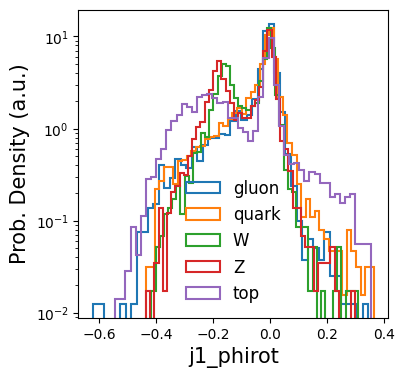

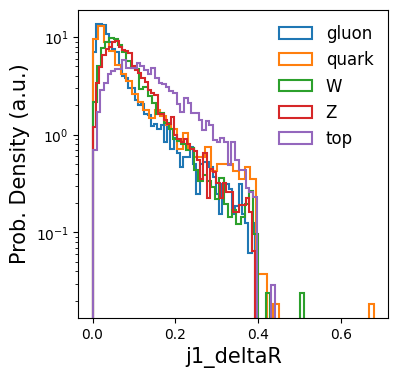

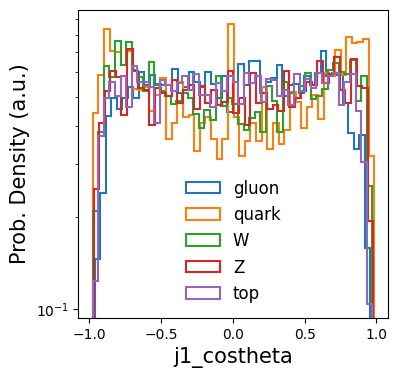

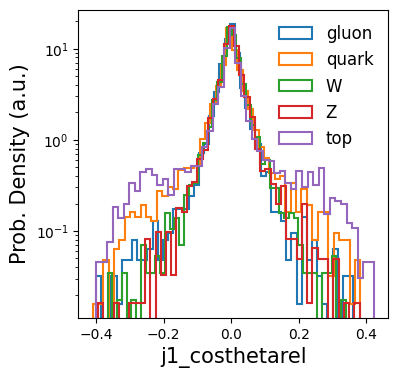

In [9]:
# plot of the features:

# this function makes the histogram of a given quantity for the five classes
def makePlot_p(feature_index, input_data, input_featurenames, labels):
    plt.subplots(figsize=(4,4))
    for i in range(len(labels)):
        my_data = input_data[:,:,feature_index]
        # notice the use of numpy masking to select specific classes of jets
        my_data = my_data[np.argmax(target, axis=1) == i]
        # then plot the right quantity for the reduced array
        plt.hist(my_data[:,feature_index].flatten(), 50, density=True, histtype='step', fill=False, linewidth=1.5)
    plt.yscale('log', nonpositive='clip', )
    plt.legend(labels, fontsize=12, frameon=False)
    plt.xlabel(input_featurenames[feature_index], fontsize=15)
    plt.ylabel('Prob. Density (a.u.)', fontsize=15)
    plt.show()

featurenames = ['j1_px','j1_py','j1_pz','j1_e','j1_erel','j1_pt','j1_ptrel',
 'j1_eta','j1_etarel','j1_etarot','j1_phi','j1_phirel','j1_phirot',
 'j1_deltaR','j1_costheta','j1_costhetarel']

labels_str = ['gluon', 'quark', 'W', 'Z', 'top']

# we now plot all the features
for i in range(len(featurenames)):
    makePlot_p(i, features, featurenames, labels_str)

In [10]:
# create jet "images": eg project each particle $p_T$ in a 100x100 eta,phi grid ceneterd around the jet direction
def create_images(features):
    jet_imgs = np.empty((features.shape[0],100,100))
    
    for i in range(features.shape[0]):
      eta = features[i,:,8]
      phi = features[i,:,11]
      pt = features[i,:,5]
      h,_,_ = np.histogram2d(eta,phi,bins=100,range=[[-1,1],[-1,1]], weights=pt)
      jet_imgs[i] = h
        
    return jet_imgs
# split in train, validation and test sets
from sklearn.model_selection import train_test_split

# Split into training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(features, label, train_size=0.8)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

jet_imgs_train = create_images(X_train)
jet_imgs_valid = create_images(X_valid)
jet_imgs_test = create_images(X_test)


(16000, 100, 16)
(16000,)
(2000, 100, 16)
(2000,)
(2000, 100, 16)
(2000,)


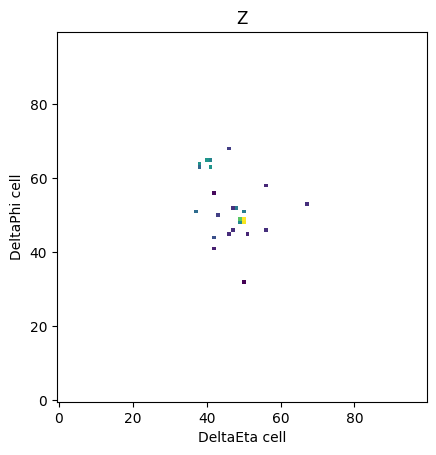

In [15]:
# print one jet image
# plot a single image to display the sparsity
from matplotlib.colors import LogNorm
def plot_single_image(jet_imgs,label,i=1):
    plt.imshow(jet_imgs[i], origin='lower',norm=LogNorm())
    plt.title(labels_str[label[i]])
    plt.xlabel('DeltaEta cell')
    plt.ylabel('DeltaPhi cell')
    plt.show()
plot_single_image(jet_imgs_train,y_train,i=1022)

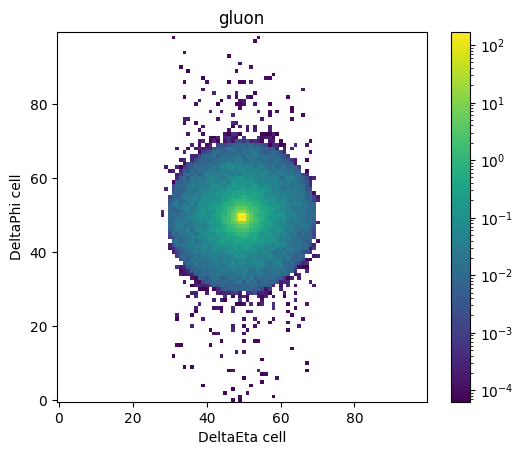

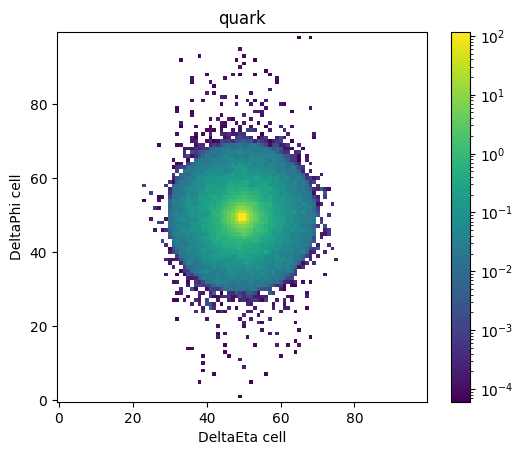

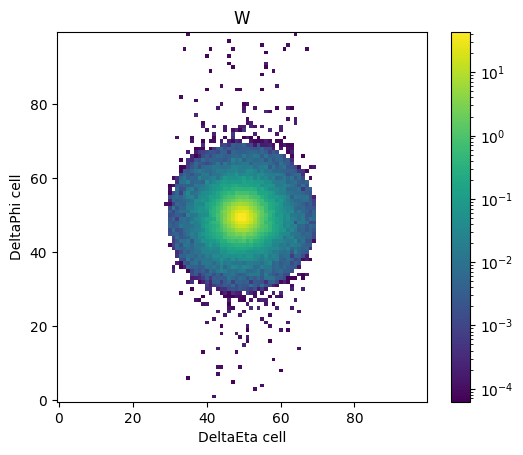

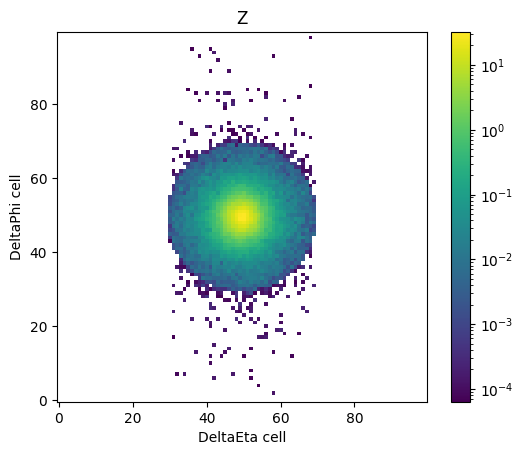

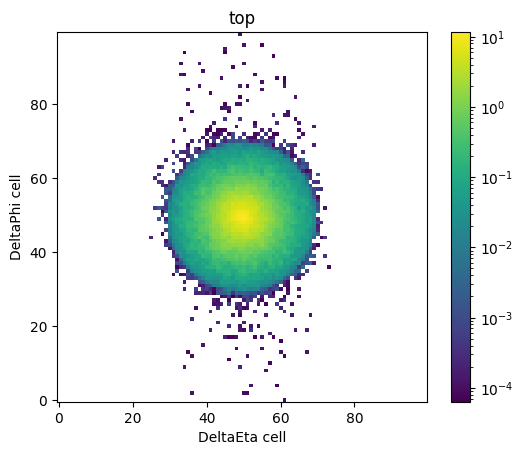

In [10]:
# plots of sum of jet images for different jet catagories
def plot_sum_images(jet_imgs,labels_str)
    image_g = jet_imgs[label==0]
    image_q = jet_imgs[label==1]
    image_W = jet_imgs[label==2]
    image_Z = jet_imgs[label==3]
    image_t = jet_imgs[label==4]
    images = [image_q, image_g, image_W, image_Z, image_t]
    
    for i in range(len(images)):
        SUM_Image = np.sum(images[i], axis = 0)
        plt.imshow(SUM_Image/float(images[i].shape[0]), origin='lower', norm=LogNorm())
        plt.colorbar()
        plt.title(labels_str[i])
        plt.xlabel('DeltaEta cell')
        plt.ylabel('DeltaPhi cell')
        plt.show()

# CNN Model

In [16]:


# normalization
from sklearn.preprocessing import MinMaxScaler ,StandardScaler
scaler = StandardScaler()
jet_imgs_train = scaler.fit_transform(jet_imgs_train.reshape(-1, 100*100)).reshape(-1, 100, 100)
jet_imgs_valid = scaler.transform(jet_imgs_valid.reshape(-1, 100*100)).reshape(-1, 100, 100)
jet_imgs_test = scaler.transform(jet_imgs_test.reshape(-1, 100*100)).reshape(-1, 100, 100)

# convert to torch tensors
jet_imgs_train = torch.tensor(jet_imgs_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

jet_imgs_valid = torch.tensor(jet_imgs_valid, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.long)

jet_imgs_test = torch.tensor(jet_imgs_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# create datasets
trainset = torch.utils.data.TensorDataset(jet_imgs_train.unsqueeze(1), y_train) #note unsqueeze needed to insert a dummy dimension after batch: (B,1,100,100)
validset = torch.utils.data.TensorDataset(jet_imgs_valid.unsqueeze(1), y_valid)
testset = torch.utils.data.TensorDataset(jet_imgs_test.unsqueeze(1), y_test)

# create dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, drop_last=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=128, shuffle=False, drop_last=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, drop_last=False)

In [17]:
# CNN model (VGG like) to process jet_imgs input for classification task of labels label

class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
    self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=0)
    self.pool = nn.MaxPool2d(2, 2)
    self.dp = nn.Dropout(p=0.5)
    self.fc1 = nn.Linear(256, 128)
    self.fc2 = nn.Linear(128, 5)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = self.pool(F.relu(self.conv4(x)))
    x = self.pool(F.relu(self.conv5(x)))
    x = torch.amax(x, (-1,-2)) # flatten all dimensions except batch
    x=self.dp(x)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

In [18]:
# training loop
import time
from torch.optim.lr_scheduler import ReduceLROnPlateau

# check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# move model to GPU
model = CNN().to(device)

# initialize loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

# training loop
num_epochs = 20
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []

best_valid_loss = float('inf')

for epoch in range(num_epochs):
    start_time = time.time()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    # set model to training mode
    model.train()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    # Validation
    valid_loss = 0.0
    valid_correct = 0
    valid_total = 0

    # set model to evaluation mode
    model.eval()
    with torch.no_grad():
        for data in validloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            valid_total += labels.size(0)
            valid_correct += (predicted == labels).sum().item()

    # Calculate epoch metrics
    train_accuracy = 100 * train_correct / train_total
    valid_accuracy = 100 * valid_correct / valid_total
    epoch_time = time.time() - start_time

    # Print and store metrics
    print('Epoch %d: train loss: %.3f, train acc: %.3f%%, valid loss: %.3f, valid acc: %.3f%%, time: %.3fs' %
          (epoch + 1, train_loss / len(trainloader), train_accuracy,
           valid_loss / len(validloader), valid_accuracy, epoch_time))

    train_losses.append(train_loss / len(trainloader))
    valid_losses.append(valid_loss / len(validloader))
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)
    scheduler.step(valid_accuracy)
    # Save model if validation loss improves
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print("Model saved!")

cuda
Epoch 1: train loss: 1.307, train acc: 45.756%, valid loss: 1.053, valid acc: 59.688%, time: 6.989s
Model saved!
Epoch 2: train loss: 1.044, train acc: 58.013%, valid loss: 0.971, valid acc: 61.094%, time: 1.232s
Model saved!
Epoch 3: train loss: 1.013, train acc: 59.244%, valid loss: 0.924, valid acc: 65.208%, time: 1.233s
Model saved!
Epoch 4: train loss: 0.953, train acc: 63.031%, valid loss: 0.921, valid acc: 64.271%, time: 1.239s
Model saved!
Epoch 5: train loss: 0.912, train acc: 64.519%, valid loss: 0.875, valid acc: 67.812%, time: 1.236s
Model saved!
Epoch 6: train loss: 0.893, train acc: 66.263%, valid loss: 0.867, valid acc: 69.479%, time: 1.240s
Model saved!
Epoch 7: train loss: 0.840, train acc: 69.256%, valid loss: 0.826, valid acc: 70.781%, time: 1.239s
Model saved!
Epoch 8: train loss: 0.834, train acc: 68.869%, valid loss: 0.871, valid acc: 69.740%, time: 1.243s
Epoch 9: train loss: 0.815, train acc: 69.912%, valid loss: 0.875, valid acc: 68.073%, time: 1.243s
Epoc

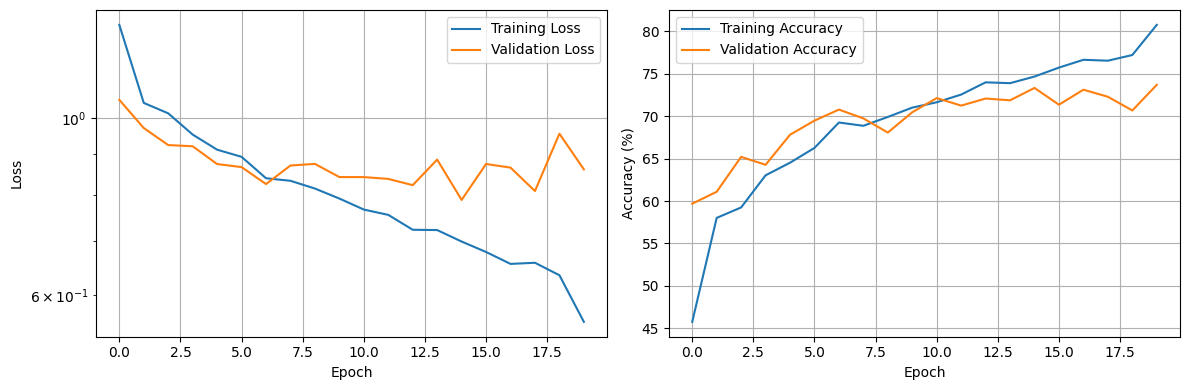

In [19]:
# plot loss and accuracy vs epoch for training and validation

# Plot loss and accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid("on")
plt.yscale("log")

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid("on")

plt.tight_layout()
plt.show()

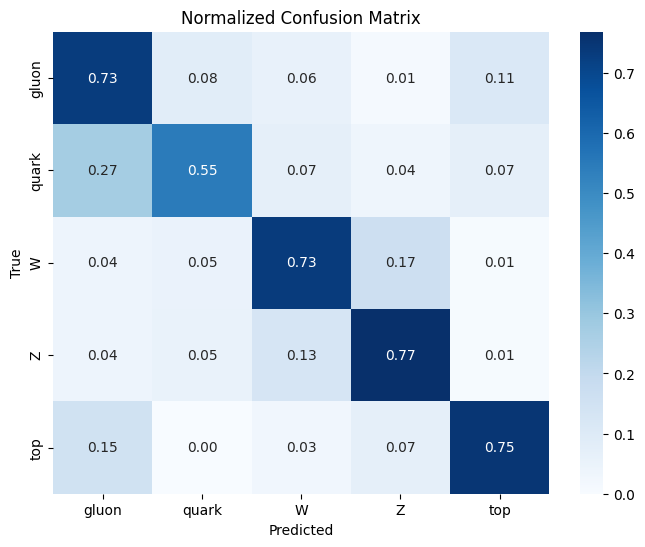

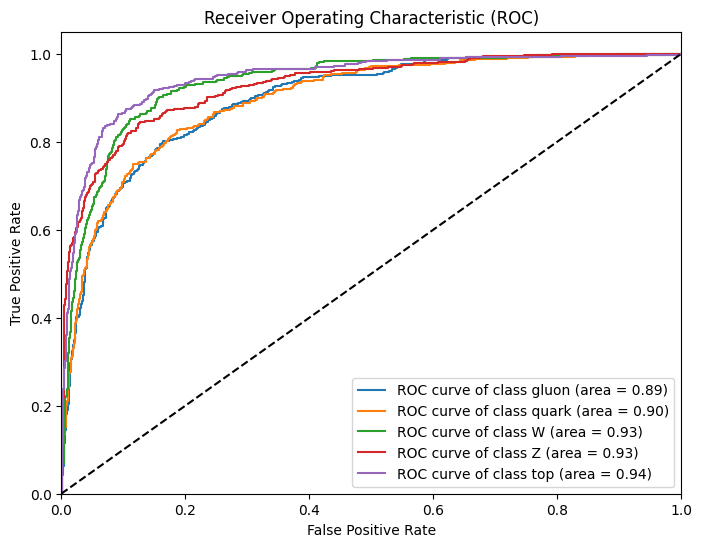

In [15]:
# Load the best saved model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Evaluate on test set
y_true = []
y_pred = []
y_score = [] # For ROC curve

with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_score.extend(F.softmax(outputs, dim=1).cpu().numpy())

import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels_str, yticklabels=labels_str)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()

# ROC curve

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 5
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.array(y_true) == i, np.array(y_score)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(labels_str[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# GNN Model

In [21]:
# create a custom graph dataset to hold the jet data
#
# Well use eta-phi rel coordinates to build the graph structure, linking via k-nn nodes (eg jet constituents) that are spatially close, and associate to
# each node a feature vector given by each particle feature vector

import torch_geometric
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import FixedPoints
from sklearn.model_selection import train_test_split
from torch_cluster import knn_graph

/leonardo/prod/opt/libraries/cineca-ai/4.1.1/none/cineca-ai-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
print(torch_geometric.__version__)
print(type(Dataset))
print(Dataset.__module__)

2.5.0
<class 'abc.ABCMeta'>
torch_geometric.data.dataset


In [23]:

class MyGraphDataset(torch_geometric.data.Dataset):
    def __init__(self, data_f, data_l, k=15, transform=None, pre_transform=None):
        super(MyGraphDataset, self).__init__(transform, pre_transform)
        self.data_f = data_f
        self.data_l = data_l
        self.num_samples = len(data_f)
        self.k = k # number of nearest neighbors

    def len(self):
        return self.num_samples

    def get(self, idx):

        graph_data = self.data_f[idx]
        graph_label = self.data_l[idx]

        # select real jet constituents (eg with pt>0)
        sel = graph_data[:,5]>0


        pos_tmp = graph_data[sel]
        pos = torch.tensor(pos_tmp[:,[8,11]], dtype=torch.float32) #eta_rel and phi_rel
        x   = torch.tensor(np.log(pos_tmp[:,5]), dtype=torch.float32)/5 #pt (you can add easily as many features as you like)
        #x   = torch.tensor((pos_tmp[:,5]), dtype=torch.float32). #pt (you can add easily as many features as you like)
        y   = torch.tensor(np.asarray(graph_label), dtype=torch.long) #targets
        category = torch.tensor(np.asarray(graph_label), dtype=torch.long)

        # compute edge_index (using pos)
        edge_index = knn_graph(pos, k=self.k, loop=False)

        # pyg data object
        data = Data(x=x, y=y, pos=pos, edge_index=edge_index, category=category)

        return data


# same split as CNN

print("train: "),print(X_train.shape), print(y_train.shape)
print("vali: "),print(X_valid.shape), print(y_valid.shape)
print("test: "),print(X_test.shape), print(y_test.shape)


train: 
(16000, 100, 16)
torch.Size([16000])
vali: 
(2000, 100, 16)
torch.Size([2000])
test: 
(2000, 100, 16)
torch.Size([2000])


(None, None, None)

In [25]:
# number of nearest neighbors
k = 8

# Create Datasets
trainset = MyGraphDataset(X_train, y_train, k=k)
validset = MyGraphDataset(X_valid, y_valid, k=k)
testset = MyGraphDataset(X_test, y_test, k=k)

# Create DataLoaders
trainloader = DataLoader(trainset, batch_size=1024, shuffle=True, drop_last=True,num_workers=8)
validloader = DataLoader(validset, batch_size=1024, shuffle=False, drop_last=False,num_workers=8)
testloader = DataLoader(testset, batch_size=128, shuffle=False, drop_last=False)

In [26]:
trainset[0]

Data(x=[37], edge_index=[2, 296], y=2, pos=[37, 2], category=2)

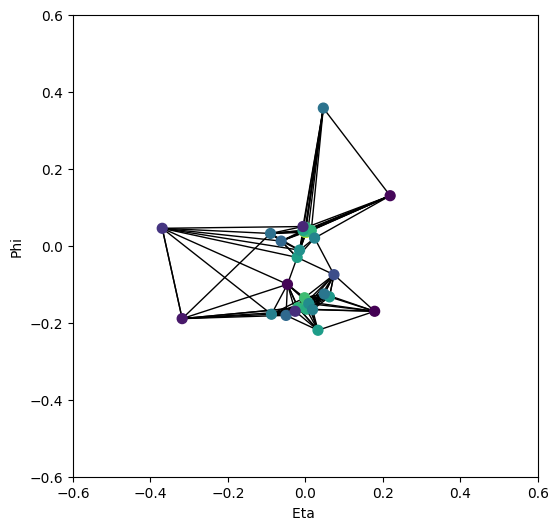

In [28]:
import matplotlib.pyplot as plt

def visualize_points(pos, x, edge_index=None, index=None):
    fig = plt.figure(figsize=(6, 6))
    if edge_index is not None:
        for (src, dst) in edge_index.t().tolist():
             src = pos[src].tolist()
             dst = pos[dst].tolist()
             plt.plot([src[0], dst[0]], [src[1], dst[1]], linewidth=1, color='black')

    if index is None:
        plt.scatter(pos[:, 0], pos[:, 1], s=50, c =(x), zorder=1000)
    else:
       mask = torch.zeros(pos.size(0), dtype=torch.bool)
       mask[index] = True
       plt.scatter(pos[~mask, 0], pos[~mask, 1], s=50, c=(x[~mask]), zorder=1000)
       plt.scatter(pos[mask, 0], pos[mask, 1], s=50, zorder=1000)

    plt.axis('on')
    plt.xlim((-0.6,0.6))
    plt.ylim((-0.6,0.6))
    plt.xlabel('Eta ')
    plt.ylabel('Phi')
    plt.show()

data = trainset[0]
visualize_points(data.pos,data.x, data.edge_index)

In [36]:
# GNN model in pytorch geometric: we'll use a simple convolutional GNN based on the GCNConv message passing graph convolution
# https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GCNConv.html


import torch.nn as nn
from torch_geometric.nn import GCNConv, global_max_pool,PointNetConv,global_mean_pool
from torch_geometric.nn.norm import BatchNorm
from torch_geometric.utils import dropout_node,dropout_edge
import torch.nn.functional as F

class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.pre_feat = nn.Linear(input_dim+2, hidden_dim)
        self.pre_feat2 = nn.Linear(hidden_dim, hidden_dim)
        self.conv1 = GCNConv(hidden_dim, hidden_dim)
        self.bn1 =BatchNorm(hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.bn2 =BatchNorm(hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.bn3 =BatchNorm(hidden_dim)
        #self.conv4 = GCNConv(hidden_dim, hidden_dim)
        #self.bn4 =BatchNorm(hidden_dim)
        #self.conv5 = GCNConv(hidden_dim, hidden_dim)
        #self.bn5 =BatchNorm(hidden_dim)
        #self.conv6 = GCNConv(hidden_dim, hidden_dim)
        #self.bn6 =BatchNorm(hidden_dim)
        self.fc = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        pos, feat, edge_index, batch = data.pos, data.x.unsqueeze(1) , data.edge_index, data.batch
        feat = torch.cat((feat, pos), dim=1)

        feat = F.relu(self.pre_feat(feat))
        feat = F.relu(self.pre_feat2(feat))
        feat = F.dropout(feat, p=0.5, training=self.training)

        x = F.relu(self.conv1(feat, edge_index))
        #x = x + feat
        x = self.bn1(x)
        x = F.relu(self.conv2(x, edge_index))
        #x = x + feat
        x = self.bn2(x)
        x = F.relu(self.conv3(x, edge_index))
        #x = x + feat
        x = self.bn3(x)
        #x = F.relu(self.conv4(x, edge_index))
        x = x + feat
        #x = self.bn4(x)
        #x = F.relu(self.conv5(x, edge_index))
        #x = x + feat
        #x = self.bn5(x)
        #x = F.relu(self.conv6(x, edge_index))
        #x = x + feat
        #x = self.bn6(x)
        x = global_mean_pool(x, batch)  # Aggregate node features
        x = F.dropout(x, p=0.5, training=self.training)
        x =  F.relu(self.fc(x))
        x = self.fc2(x)
        return x

In [37]:
# test the model on one batch
from torch_geometric.nn import summary
model = GNN(input_dim=1, hidden_dim=128, output_dim=5)
data = next(iter(trainloader))
output = model(data)
print(output.shape)
print(summary(model, data))

torch.Size([1024, 5])
+----------------------------+---------------------------+----------------+----------+
| Layer                      | Input Shape               | Output Shape   | #Param   |
|----------------------------+---------------------------+----------------+----------|
| GNN                        | [50319, 50319]            | [1024, 5]      | 84,485   |
| ├─(pre_feat)Linear         | [50319, 3]                | [50319, 128]   | 512      |
| ├─(pre_feat2)Linear        | [50319, 128]              | [50319, 128]   | 16,512   |
| ├─(conv1)GCNConv           | [50319, 128], [2, 402552] | [50319, 128]   | 16,512   |
| ├─(bn1)BatchNorm           | [50319, 128]              | [50319, 128]   | 256      |
| │    └─(module)BatchNorm1d | [50319, 128]              | [50319, 128]   | 256      |
| ├─(conv2)GCNConv           | [50319, 128], [2, 402552] | [50319, 128]   | 16,512   |
| ├─(bn2)BatchNorm           | [50319, 128]              | [50319, 128]   | 256      |
| │    └─(module)Batc

In [38]:
import torch_scatter
print(torch_scatter.__version__)

2.1.2


In [ ]:
# training loop
import time

# check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# move model to GPU
model = GNN(input_dim=1, hidden_dim=128, output_dim=5).to(device)


# initialize loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.03)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, verbose=True)

# training loop
num_epochs = 150
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []

best_valid_loss = float('inf')

for epoch in range(num_epochs):
    start_time = time.time()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    # set model to training mode
    model.train()
    for i, batch in enumerate(trainloader):
        batch = batch.to(device)
        optimizer.zero_grad()
        outputs = model(batch)
        loss = criterion(outputs, batch.y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += batch.y.size(0)
        train_correct += (predicted == batch.y).sum().item()

    # Validation
    valid_loss = 0.0
    valid_correct = 0
    valid_total = 0

    # set model to evaluation mode
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(validloader):
            batch = batch.to(device)
            outputs = model(batch)
            loss = criterion(outputs, batch.y)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            valid_total += batch.y.size(0)
            valid_correct += (predicted == batch.y).sum().item()

    # Calculate epoch metrics
    train_accuracy = 100 * train_correct / train_total
    valid_accuracy = 100 * valid_correct / valid_total
    epoch_time = time.time() - start_time

    # Print and store metrics
    print('Epoch %d: train loss: %.3f, train acc: %.3f%%, valid loss: %.3f, valid acc: %.3f%%, time: %.3fs' %
          (epoch + 1, train_loss / len(trainloader), train_accuracy,
           valid_loss / len(validloader), valid_accuracy, epoch_time))

    train_losses.append(train_loss / len(trainloader))
    valid_losses.append(valid_loss / len(validloader))
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)
    scheduler.step(valid_accuracy)
    print("lr: ", optimizer.param_groups[0]['lr'])

    # Save model if validation loss improves
    if valid_loss/len(validloader) < best_valid_loss:
        best_valid_loss = valid_loss/len(validloader)
        torch.save(model.state_dict(), 'best_model_gnn.pth')
        print("Model saved!")

cuda
Epoch 1: train loss: 1.559, train acc: 30.970%, valid loss: 1.562, valid acc: 32.950%, time: 2.848s
lr:  0.03
Model saved!
Epoch 2: train loss: 1.273, train acc: 46.178%, valid loss: 1.473, valid acc: 43.100%, time: 2.934s
lr:  0.03
Model saved!
Epoch 3: train loss: 1.132, train acc: 54.134%, valid loss: 1.129, valid acc: 56.350%, time: 2.879s
lr:  0.03
Model saved!
Epoch 4: train loss: 1.088, train acc: 56.465%, valid loss: 1.278, valid acc: 46.750%, time: 3.156s
lr:  0.03
Epoch 5: train loss: 1.066, train acc: 56.667%, valid loss: 1.029, valid acc: 59.250%, time: 3.082s
lr:  0.03
Model saved!
Epoch 6: train loss: 1.043, train acc: 57.741%, valid loss: 1.005, valid acc: 61.000%, time: 3.017s
lr:  0.03
Model saved!
Epoch 7: train loss: 1.026, train acc: 59.115%, valid loss: 1.071, valid acc: 57.400%, time: 3.068s
lr:  0.03
Epoch 8: train loss: 1.012, train acc: 60.130%, valid loss: 0.967, valid acc: 63.400%, time: 3.051s
lr:  0.03
Model saved!
Epoch 9: train loss: 1.005, train acc

In [ ]:
# plot loss and accuracy vs epoch for training and validation

# Plot loss and accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.yscale('log')
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()



plt.tight_layout()
plt.grid()
plt.show()

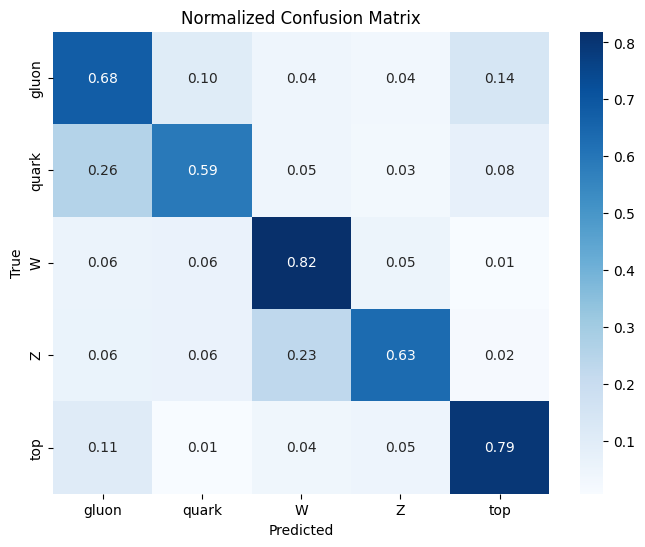

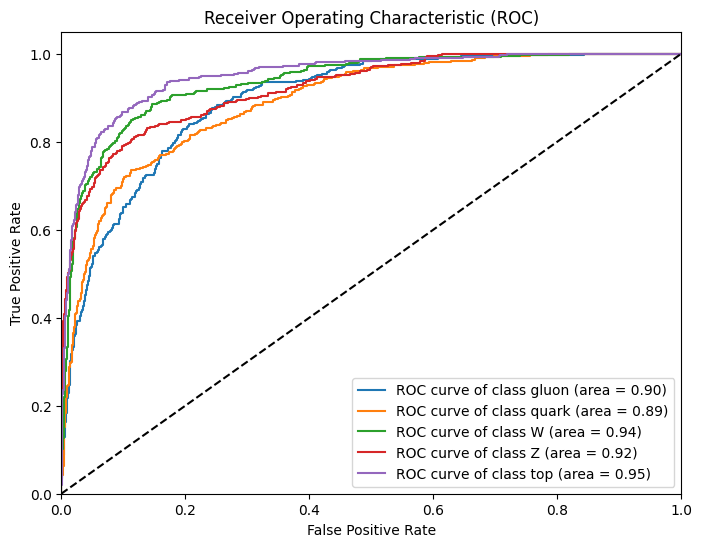

In [34]:
# Load the best saved model
model.load_state_dict(torch.load('best_model_gnn.pth'))
model.eval()

# Evaluate on test set
y_true = []
y_pred = []
y_score = [] # For ROC curve

with torch.no_grad():
    for batch in testloader:
        batch = batch.to(device)
        outputs = model(batch)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(batch.y.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_score.extend(F.softmax(outputs, dim=1).cpu().numpy())

import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels_str, yticklabels=labels_str)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()

# ROC curve

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 5
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.array(y_true) == i, np.array(y_score)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(labels_str[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()